In [177]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivat(dA, x):
    """
    sigmoid'(x) = x' * sigmoid(x) * (1 - sigmoid(x))
    """
    f = sigmoid(x)
    
    return dA * f * (1 - f)

def relu_derivat(dA, x):
    """ relu'(x) = [0, daca x <=0 altfel 1] * x' """
    dX = np.array(dA, copy=True)
    dX[x <= 0] = 0
    
    return dX

In [298]:
def bce(y, y_hat):
    n = y.shape[1]
    
    loss = (-1 / n) * (np.dot(y, np.log(y_hat).T) + np.dot(1 - y, np.log(1 - y_hat).T))
    
    return np.squeeze(loss)

def accuracy_score(y, y_hat):
    classes = (y_hat >= 0.5).astype(int)

    return (classes == y).mean()

In [529]:
class MLP():
    """
    Varianta definire MLP cu specificare input si output pentru fiecare unitate.
    """
    def __init__(self, architecture, random_seed=42):
        np.random.seed(random_seed)
        
        self.activation_functions = {
            'sigmoid': sigmoid,
            'relu': relu
        }
        
        self.derivatives = {
            'relu': relu_derivat,
            'sigmoid': sigmoid_derivat
        }
        
        
        number_of_layers = len(architecture)
        params_values = {}

        for idx, layer in enumerate(architecture):
            layer_idx = idx + 1
            
            layer_input_size = layer["input_dim"]
            
            layer_output_size = layer["units"]

            params_values['W' + str(layer_idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.1
            
            params_values['b' + str(layer_idx)] = np.random.randn(layer_output_size, 1) * 0.1
            
            
        self.params = params_values
        self.architecture = architecture
        
    def summary(self):
        print("{:^15s} {:^15s} {:^15s} {:^15s} {:^15s} {:^15s} \n".format(
            "Input shape",
            "Output shape",
            "Weights shape",
            "Bias shape",
            "Activation",
            "Params"
        ))
        print("{:_<100s}".format(''))
        total_params = 0
        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            in_shape = layer["input_dim"]
            out_shape = layer["units"]
            
            weights_shape = self.params['W' + str(layer_idx)].shape
            bias_shape = self.params['b' + str(layer_idx)].shape
            
            activation = layer["activation"]
            
            weights_params = 1
            for dim in weights_shape:
                weights_params *= dim
            
            bias_params = 1
            for dim in bias_shape:
                bias_params *= dim
            
            num_params = bias_params + weights_params
            total_params += num_params
            
            print("{:^15d} {:^15d} {:^15s} {:^15s} {:^15s} {:^15d} \n".format(
                in_shape,
                out_shape,
                str(weights_shape),
                str(bias_shape),
                activation,
                num_params
            ))
            print("-"*100)
            
        print("Total number of parameters: {}".format(total_params))

    def forward(self, w, b, x, activation='relu'):
        z = np.dot(w, x) + b
    
        return self.activation_functions[activation](z), z
        
    def predict(self, x):
        """ Functie cu care realizam predictii prin metoda propagarii inainte. """
        memory = {}
        current_activation = x

        for idx, layer in enumerate(self.architecture):
            layer_idx = idx + 1
            previous_activation = current_activation
            
            activation_function = layer["activation"]
            
            w = self.params["W" + str(layer_idx)]
            
            b = self.params["b" + str(layer_idx)]

            current_activation, z = self.forward(w, b, previous_activation, activation_function)

            memory["x" + str(idx)] = previous_activation
            memory["z" + str(layer_idx)] = z

        return current_activation, memory
    
    def backward(self, dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        # number of examples
        m = A_prev.shape[1]

        # selection of activation function
        if activation is "relu":
            backward_activation_func = relu_derivat
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_derivat
        else:
            raise Exception('Non-supported activation function')

        # calculation of the activation function derivative
        dZ_curr = backward_activation_func(dA_curr, Z_curr)

        # derivative of the matrix W
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        # derivative of the vector b
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        # derivative of the matrix A_prev
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr
    
    def backward_propagation(self, Y_hat, Y, memory):
        grads_values = {}
    
        # number of examples
        m = Y.shape[1]
        # a hack ensuring the same shape of the prediction vector and labels vector
        Y = Y.reshape(Y_hat.shape)

        # initiation of gradient descent algorithm
        dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

        for layer_idx_prev, layer in reversed(list(enumerate(self.architecture))):
            # we number network layers from 1
            layer_idx_curr = layer_idx_prev + 1
            # extraction of the activation function for the current layer
            activ_function_curr = layer["activation"]

            dA_curr = dA_prev

            A_prev = memory["x" + str(layer_idx_prev)]
            Z_curr = memory["z" + str(layer_idx_curr)]

            W_curr = self.params["W" + str(layer_idx_curr)]
            b_curr = self.params["b" + str(layer_idx_curr)]

            dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
                dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)

            grads_values["dW" + str(layer_idx_curr)] = dW_curr
            grads_values["db" + str(layer_idx_curr)] = db_curr

        return grads_values
    
    def update(self, grads_values, learning_rate):
        for layer_idx, layer in enumerate(self.architecture, 1):
            self.params["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
            self.params["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]
            
    def train(self, X, Y, epochs, learning_rate):
        cost_history = []
        accuracy_history = []

        for i in range(epochs):
            Y_hat, mem = self.predict(X)
            cost = bce(Y, Y_hat)
            
            cost_history.append(cost)
            accuracy = accuracy_score(Y, Y_hat)
            accuracy_history.append(accuracy)

            grads_values = self.backward_propagation(Y_hat, Y, mem)
            
            self.update(grads_values, learning_rate)
            
            if(i % 50 == 0):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))

        return cost_history, accuracy_history

In [530]:
architecture = [
    {
        "input_dim": 2,
        "units": 25,
        "activation": "relu"
    },
    {
        "input_dim": 25,
        "units": 50,
        "activation": "relu"
    },
    {
        "input_dim": 50,
        "units": 50,
        "activation": "relu"
    },
    {
        "input_dim": 50,
        "units": 25,
        "activation": "relu"
    },
    {
        "input_dim": 25,
        "units": 1,
        "activation": "sigmoid"
    },
]

In [531]:
nn = MLP(architecture)

In [532]:
nn.summary()

  Input shape    Output shape    Weights shape    Bias shape      Activation        Params      

____________________________________________________________________________________________________
       2              25            (25, 2)         (25, 1)          relu             75        

----------------------------------------------------------------------------------------------------
      25              50           (50, 25)         (50, 1)          relu            1300       

----------------------------------------------------------------------------------------------------
      50              50           (50, 50)         (50, 1)          relu            2550       

----------------------------------------------------------------------------------------------------
      50              25           (25, 50)         (25, 1)          relu            1275       

----------------------------------------------------------------------------------------------------
     

In [533]:
X, y = make_moons(n_samples = 1000, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [534]:
X.shape

(1000, 2)

In [535]:
y.shape

(1000,)

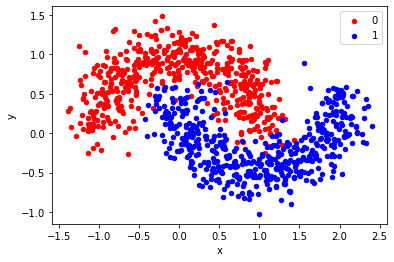

In [536]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [537]:
hist = nn.train(X_train.T, y_train.reshape(1, y_train.shape[0]), 10000, 0.1)

Iteration: 00000 - cost: 0.69509 - accuracy: 0.49556
Iteration: 00050 - cost: 0.69228 - accuracy: 0.49667
Iteration: 00100 - cost: 0.69102 - accuracy: 0.50444
Iteration: 00150 - cost: 0.68836 - accuracy: 0.67556
Iteration: 00200 - cost: 0.68028 - accuracy: 0.82444
Iteration: 00250 - cost: 0.64183 - accuracy: 0.84000
Iteration: 00300 - cost: 0.43950 - accuracy: 0.85444
Iteration: 00350 - cost: 0.29377 - accuracy: 0.87667
Iteration: 00400 - cost: 0.28068 - accuracy: 0.87778
Iteration: 00450 - cost: 0.27648 - accuracy: 0.88000
Iteration: 00500 - cost: 0.27201 - accuracy: 0.88111
Iteration: 00550 - cost: 0.26648 - accuracy: 0.88000
Iteration: 00600 - cost: 0.25979 - accuracy: 0.88000
Iteration: 00650 - cost: 0.25365 - accuracy: 0.88333
Iteration: 00700 - cost: 0.24837 - accuracy: 0.88556
Iteration: 00750 - cost: 0.24416 - accuracy: 0.88667
Iteration: 00800 - cost: 0.23042 - accuracy: 0.89222
Iteration: 00850 - cost: 0.21399 - accuracy: 0.90000
Iteration: 00900 - cost: 0.18444 - accuracy: 0

Iteration: 07800 - cost: 0.06093 - accuracy: 0.97222
Iteration: 07850 - cost: 0.06089 - accuracy: 0.97222
Iteration: 07900 - cost: 0.06087 - accuracy: 0.97222
Iteration: 07950 - cost: 0.06088 - accuracy: 0.97222
Iteration: 08000 - cost: 0.06085 - accuracy: 0.97222
Iteration: 08050 - cost: 0.06090 - accuracy: 0.97222
Iteration: 08100 - cost: 0.06089 - accuracy: 0.97222
Iteration: 08150 - cost: 0.06073 - accuracy: 0.97222
Iteration: 08200 - cost: 0.06089 - accuracy: 0.97222
Iteration: 08250 - cost: 0.06090 - accuracy: 0.97222
Iteration: 08300 - cost: 0.06071 - accuracy: 0.97222
Iteration: 08350 - cost: 0.06069 - accuracy: 0.97222
Iteration: 08400 - cost: 0.06073 - accuracy: 0.97222
Iteration: 08450 - cost: 0.06080 - accuracy: 0.97222
Iteration: 08500 - cost: 0.06071 - accuracy: 0.97222
Iteration: 08550 - cost: 0.06067 - accuracy: 0.97222
Iteration: 08600 - cost: 0.06067 - accuracy: 0.97222
Iteration: 08650 - cost: 0.06074 - accuracy: 0.97222
Iteration: 08700 - cost: 0.06071 - accuracy: 0

In [538]:
pred, _ = nn.predict(X_test.T)

In [540]:
accuracy_score(y_test, pred)

1.0